In [1]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
import numpy as np
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lbAlldrugs=pd.read_excel('allOtherDrugs_carvemeNcurated.xlsx', header=0, index_col=0)
pvalueCol=lbAlldrugs.columns[-3]
lbAlldrugs.head()

,prestwickID,drugName,StitchInhibtProteins,modelInhibtProteins,AffectedRxs,Growth%Change,CURATEDInhibtProteins,CURATEDAffectedRxs,CURATEDGrowth%Change,Bacteroides thetaiotaomicron (NT5004),targetSpecies,CIDno
236,Prestw-1109,Rifabutin,3,1,0,0,0,0,0,0.000009,bacteria,5361912
239,Prestw-1233,Auranofin,3,3,16,0,3,4,0,0.000009,human,6333887
237,Prestw-525,Rifampicin,3,1,0,0,0,0,0,0.000009,bacteria,5381226
78,Prestw-151,Erythromycin,3,1,0,0,0,0,0,0.000010,bacteria,3255
95,Prestw-808,Furazolidone,1,1,1156,100,1,780,100,0.000010,bacteria,3435


## effect in vitro

In [3]:
LBcarveme=lbAlldrugs.copy()
LBcarveme=LBcarveme[LBcarveme[pvalueCol] <= 0.01]
# LBcarveme=LBcarveme[['drugId','CID_no','drugName', 'STITCH','Model', 'LB_FBA_before', 'LB_FBA_after']]
LBcarveme=LBcarveme[['prestwickID','StitchInhibtProteins','modelInhibtProteins', 'Growth%Change']]
# print(LBcarveme)

# LBcarveme=LBcarveme.melt(id_vars=['drugId','CID_no', 'drugName', 'LB_FBA_before', 'LB_FBA_after'], var_name="CountingSource", value_name="InhibitedProteins").sort_values("drugId").reset_index(drop=True)
LBcarveme=LBcarveme.melt(id_vars=['prestwickID', 'Growth%Change'], var_name="CountingSource", value_name="InhibitedProteins")
LBcarveme=LBcarveme.sort_values(['prestwickID','CountingSource'],ascending=False).groupby('prestwickID').head()

LBcarveme=LBcarveme.reset_index(drop=True)

LBcarveme['EffectOnGrowth'] = np.nan
LBcarveme['EffectOnGrowth'] = LBcarveme['EffectOnGrowth'].astype(str)

for index, row in LBcarveme.iterrows():
#     print(row['growthDiff'])
    if row['Growth%Change']==100: #if the drug inhibits growth (random number)      
        LBcarveme.at[index,'EffectOnGrowth']="Effect"
    else:
        LBcarveme.at[index,'EffectOnGrowth']="noEffect"

# LBcarveme['CountingSource'] = LBcarveme['CountingSource'].astype(str)

LBcarveme=LBcarveme.drop(columns=['Growth%Change'])
LBcarveme

,prestwickID,CountingSource,InhibitedProteins,EffectOnGrowth
0,Prestw-808,modelInhibtProteins,1,Effect
1,Prestw-808,StitchInhibtProteins,1,Effect
2,Prestw-766,modelInhibtProteins,1,noEffect
3,Prestw-766,StitchInhibtProteins,3,noEffect
4,Prestw-756,modelInhibtProteins,4,noEffect
...,...,...,...,...
73,Prestw-1109,StitchInhibtProteins,3,noEffect
74,Prestw-1056,modelInhibtProteins,1,noEffect
75,Prestw-1056,StitchInhibtProteins,1,noEffect
76,Prestw-1,modelInhibtProteins,1,noEffect


In [4]:
LBcurated=lbAlldrugs.copy()
LBcurated=LBcurated[LBcurated[pvalueCol] <= 0.01]
# LBcurated=LBcurated[['drugId','CID_no','drugName', 'STITCH','Model', 'LB_FBA_before', 'LB_FBA_after']]
LBcurated=LBcurated[['prestwickID','StitchInhibtProteins','CURATEDInhibtProteins', 'CURATEDGrowth%Change']]
# print(LBcurated)

# LBcurated=LBcurated.melt(id_vars=['drugId','CID_no', 'drugName', 'LB_FBA_before', 'LB_FBA_after'], var_name="CountingSource", value_name="InhibitedProteins").sort_values("drugId").reset_index(drop=True)
LBcurated=LBcurated.melt(id_vars=['prestwickID', 'CURATEDGrowth%Change'], var_name="CountingSource", value_name="InhibitedProteins")
LBcurated=LBcurated.sort_values(['prestwickID','CountingSource'],ascending=False).groupby('prestwickID').head()

LBcurated=LBcurated.reset_index(drop=True)

LBcurated['EffectOnGrowth'] = np.nan
LBcurated['EffectOnGrowth'] = LBcurated['EffectOnGrowth'].astype(str)

for index, row in LBcurated.iterrows():
#     print(row['growthDiff'])
    if row['CURATEDGrowth%Change']==100: #if the drug inhibits growth (random number)      
        LBcurated.at[index,'EffectOnGrowth']="Effect"
    else:
        LBcurated.at[index,'EffectOnGrowth']="noEffect"

# LBcurated['CountingSource'] = LBcurated['CountingSource'].astype(str)

LBcurated=LBcurated.drop(columns=['CURATEDGrowth%Change'])
# LBcurated

In [5]:
dfs=pd.concat([LBcarveme, LBcurated])

dfs=dfs.sort_values(['prestwickID','CountingSource'],ascending=True).groupby('prestwickID').head(100)
dfs=dfs.reset_index(drop=True)
dfs

,prestwickID,CountingSource,InhibitedProteins,EffectOnGrowth
0,Prestw-1,CURATEDInhibtProteins,1,noEffect
1,Prestw-1,StitchInhibtProteins,1,noEffect
2,Prestw-1,StitchInhibtProteins,1,noEffect
3,Prestw-1,modelInhibtProteins,1,noEffect
4,Prestw-1056,CURATEDInhibtProteins,1,noEffect
...,...,...,...,...
151,Prestw-766,modelInhibtProteins,1,noEffect
152,Prestw-808,CURATEDInhibtProteins,1,Effect
153,Prestw-808,StitchInhibtProteins,1,Effect
154,Prestw-808,StitchInhibtProteins,1,Effect


/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 67.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 56.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


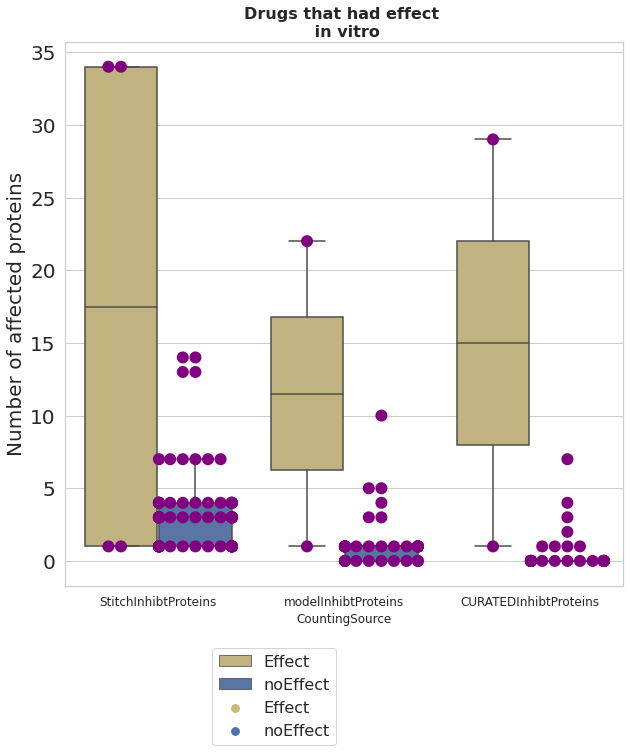

In [6]:
plt.figure(figsize = (10,10))
carvemeDF=dfs.copy()
sns.set_theme(style="whitegrid")

g=sns.boxplot(y='InhibitedProteins', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF,order=['StitchInhibtProteins', 'modelInhibtProteins','CURATEDInhibtProteins'],hue_order=['Effect', 'noEffect'], palette=dict(Effect = 'y', noEffect = 'b'))

# , order=['StitchInhibtProteins', 'modelInhibtProteins','CURATEDInhibtProteins']

g=sns.swarmplot(y='InhibitedProteins', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF, order=['StitchInhibtProteins', 'modelInhibtProteins','CURATEDInhibtProteins'],hue_order=['Effect', 'noEffect'],color='black', palette=dict(Effect = 'y', noEffect = 'b'), linewidth=6,edgecolor='purple',  size=6, dodge=True)
# g=sns.stripplot(y='InhibitedProteins', x='CountingSource', hue='EffectOnGrowth', data=carvemeDF, color='black', linewidth=4,edgecolor='red',  size=5, dodge=True)

plt.title("Drugs that had effect \n in vitro",fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)
# plt.xlabel(['STITCH', 'Carveme', 'Curated'],fontsize=16)
plt.ylabel('Number of affected proteins',fontsize=20)
horiz_offset = 0.5
vert_offset = -0.1
plt.legend(bbox_to_anchor=(horiz_offset, vert_offset),fontsize=16)
# g=sns.set(rc={'figure.figsize':(50,50)})
# plt.savefig("carveme_boxplot_Drugs.png")
# plt.savefig('allOtherDrugs_proteinsBoxplot.pdf', format="pdf",bbox_inches="tight")
# plt.savefig('allOtherDrugs_proteinsBoxplot.png',bbox_inches="tight")